In [ ]:
import os
import csv
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib
import matplotlib.pyplot as plt

In [2]:
# Đường dẫn gốc dataset
dataset_root = r"C:\Users\admin\Documents\Học máy"

# Đường dẫn tới folder Train và Test
train_dir = os.path.join(dataset_root, "public_train3")
test_dir = os.path.join(dataset_root, "public_test")

print("Train folder:", train_dir)
print("Test folder:", test_dir)

# Lấy danh sách file trong từng folder
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print(f"Tổng số file train: {len(train_files)}")
print(f"Tổng số file test: {len(test_files)}")

# Nếu muốn duyệt qua từng video trong Train
for video in train_files[:5]:  # In thử 5 video đầu
    print("Video train:", os.path.join(train_dir, video))


Train folder: C:\Users\admin\Documents\Học máy\public_train3
Test folder: C:\Users\admin\Documents\Học máy\public_test
Tổng số file train: 253
Tổng số file test: 60
Video train: C:\Users\admin\Documents\Học máy\public_train3\0.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train3\1.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train3\10.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train3\100.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train3\101.mp4


In [3]:
def split_videos_by_label(csv_path, video_dir, output_dir, seed=42):
    df = pd.read_csv(csv_path)

    # Xóa thư mục cũ (nếu có)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    # Kiểm tra trùng filename
    if df['filename'].duplicated().sum() > 0:
        print("⚠ Cảnh báo: CSV có filename trùng lặp!")
        df = df.drop_duplicates(subset=['filename'])  # Hoặc xử lý thủ công

    # Stratified split
    train_df, temp_df = train_test_split(
        df, test_size=0.4, stratify=df['label'], random_state=seed
    )

    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label'], random_state=seed
    )

    # Tạo thư mục
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    def copy_files(df_split, split_name):
        split_path = os.path.join(output_dir, split_name)
        copied_count = 0
        for _, row in df_split.iterrows():
            src = os.path.join(video_dir, row['filename'])
            dst = os.path.join(split_path, row['filename'])
            if os.path.exists(src):
                shutil.copy(src, dst)
                copied_count += 1
        print(f"{split_name}: Đã copy {copied_count} video")

    copy_files(train_df, 'train')
    copy_files(val_df, 'val')
    copy_files(test_df, 'test')



In [4]:
split_videos_by_label(
    csv_path=r"C:\Users\admin\Documents\Học máy\public_train3\public_train_label.csv",
    video_dir=r"C:\Users\admin\Documents\Học máy\public_train3",
    output_dir=r"C:\Users\admin\Documents\Học máy\Dataset3"
)

train: Đã copy 151 video
val: Đã copy 50 video
test: Đã copy 51 video


In [6]:
# Khởi tạo Mediapipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils  

def preprocess_video_display(video_path):
    cap = cv2.VideoCapture(video_path)
    target_size = (640, 480) # move target_size here

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.3,
        min_tracking_confidence=0.3
    ) as hands:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, target_size)

            # Chuyển sang RGB cho Mediapipe
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb)

            if results.multi_hand_landmarks:
                h, w, _ = frame.shape
                for hand_landmarks in results.multi_hand_landmarks:
                    # Vẽ landmarks
                    mp_drawing.draw_landmarks(
                        frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                    # Tính bounding box
                    # Use list comprehension and numpy for faster calculation
                    x_coords = [lm.x for lm in hand_landmarks.landmark]
                    y_coords = [lm.y for lm in hand_landmarks.landmark]

                    x_min = min(x_coords) * w
                    x_max = max(x_coords) * w
                    y_min = min(y_coords) * h
                    y_max = max(y_coords) * h

                    # Padding
                    x_min, y_min = max(0, int(x_min) - 30), max(0, int(y_min) - 30)
                    x_max, y_max = min(w, int(x_max) + 30), min(h, int(y_max) + 30)

                    # Vẽ bounding box quanh tay
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Hiển thị videos
            cv2.imshow("Video with Hand Detection", frame)

            # Nhấn 'q' để thoát
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [7]:
video_path = r"C:\Users\admin\Documents\Học máy\public_train3\234.mp4"
preprocess_video_display(video_path)

In [ ]:

# Khởi tạo các công cụ vẽ của MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def extract_and_save_keypoints(video_path, output_csv="hand.csv", max_num_hands=2):
    # video_path=0 nghĩa là dùng Webcam. Nếu dùng file video thì truyền đường dẫn vào "video.mp4"
    
    cap = cv2.VideoCapture(video_path)
    num_landmarks = 21 
    
    # 1. TẠO HEADER CSV
    # Chia rõ cột cho Tay Trái (Left) và Tay Phải (Right)
    header = ["frame_idx"] 
    for h in ["Left", "Right"]: 
        for i in range(num_landmarks):
            header.extend([f"{h}_x{i}", f"{h}_y{i}", f"{h}_z{i}"])
            
    # Mở file CSV để ghi
    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

        with mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=max_num_hands,
            min_detection_confidence=0.5, # Độ tin cậy
            min_tracking_confidence=0.5,
        ) as hands:
            
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Quan trọng: Lật ảnh (Flip) để giống soi gương, giúp "Left" đúng là tay trái của bạn
                frame = cv2.flip(frame, 1)

                # --- TẠO BẢNG TRẮNG ĐỂ VẼ SKELETON ---
                skeleton_frame = np.ones_like(frame) * 255 

                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = hands.process(rgb)
                
                # Tạo vector dữ liệu rỗng (toàn số 0)
                # 63 số đầu (Left) + 63 số sau (Right)
                row_data = [0.0] * (num_landmarks * 3 * 2) 
                
                if results.multi_hand_landmarks and results.multi_handedness:
                    for idx, hand_handedness in enumerate(results.multi_handedness):
                        # Lấy nhãn: "Left" hoặc "Right"
                        label = hand_handedness.classification[0].label 
                        hand_landmarks = results.multi_hand_landmarks[idx]
                        
                        # --- A. LẤY DỮ LIỆU ---
                        flat_landmarks = []
                        for lm in hand_landmarks.landmark:
                            flat_landmarks.extend([lm.x, lm.y, lm.z])
                        
                        # Điền vào đúng vị trí (Trái trước, Phải sau)
                        if label == "Left":
                            row_data[0:63] = flat_landmarks
                        else: # Right
                            row_data[63:126] = flat_landmarks

                        # --- B. VẼ VISUALIZATION (PHẦN BẠN CẦN) ---
                        
                        # 1. Vẽ lên Video gốc
                        mp_drawing.draw_landmarks(
                            frame,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())
                        
                        # 2. Vẽ lên Bảng trắng (Skeleton)
                        mp_drawing.draw_landmarks(
                            skeleton_frame,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            # Màu điểm khớp (Đỏ)
                            mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2),
                            # Màu đường nối (Xanh lá)
                            mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2)
                        )

                # Ghi CSV
                writer.writerow([frame_idx] + row_data)
                frame_idx += 1

                # --- HIỂN THỊ ---
                # Ghép 2 khung hình lại: Bên trái là Camera, Bên phải là Skeleton
                combined = np.hstack((frame, skeleton_frame))
                
                cv2.imshow("Trai: Camera | Phai: Skeleton", combined)
                
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()
    print(f" Đã lưu keypoints vào {output_csv}")



In [9]:
extract_and_save_keypoints(video_path)

✅ Đã lưu keypoints vào hand.csv


In [ ]:
def augment_flat_keypoints(df, noise_std=0.01, rotate_deg=10, scale_range=(0.9, 1.1), translate_range=0.05):
    augmented = df.copy()

    # 1. Lấy danh sách cột tọa độ (giữ nguyên logic này vì nó tự động bắt được _x, _y, _z)
    coord_cols = [c for c in df.columns if any(axis in c for axis in ['_x', '_y', '_z'])]

    # --- A. Gaussian noise (Thêm nhiễu) ---
    # Giúp model không bị "học vẹt" các toạ độ tuyệt đối
    augmented[coord_cols] += np.random.normal(0, noise_std, size=augmented[coord_cols].shape)

    # --- B. Scale (Phóng to / Thu nhỏ) ---
    # Mô phỏng tay to/nhỏ hoặc xa/gần camera
    scale = np.random.uniform(scale_range[0], scale_range[1])
    augmented[coord_cols] *= scale

    # --- C. Translation (Dịch chuyển) ---
    # Mô phỏng tay di chuyển sang trái/phải/lên/xuống trong khung hình
    tx = np.random.uniform(-translate_range, translate_range)
    ty = np.random.uniform(-translate_range, translate_range)
    
    # SỬA: Dùng Left/Right và range(21)
    num_landmarks = 21
    for hand in ['Left', 'Right']: 
        for i in range(num_landmarks): 
            # Kiểm tra cột có tồn tại không trước khi cộng
            if f"{hand}_x{i}" in augmented.columns:
                augmented[f"{hand}_x{i}"] += tx
            if f"{hand}_y{i}" in augmented.columns:
                augmented[f"{hand}_y{i}"] += ty

    # --- D. Rotation (Xoay) ---
    # Mô phỏng cổ tay xoay nghiêng
    angle_rad = np.deg2rad(np.random.uniform(-rotate_deg, rotate_deg))
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    for hand in ['Left', 'Right']:
        # Tạo danh sách tên cột x và y cho tay hiện tại (0 -> 20)
        xs_cols = [f"{hand}_x{i}" for i in range(num_landmarks)]
        ys_cols = [f"{hand}_y{i}" for i in range(num_landmarks)]
        
        # Chỉ xử lý nếu cột tồn tại trong file CSV
        if not set(xs_cols).issubset(augmented.columns):
            continue

        # Lấy dữ liệu dạng ma trận (N rows x 21 landmarks)
        xs = augmented[xs_cols].values
        ys = augmented[ys_cols].values

        # Tính tâm xoay (Centroid) của từng bàn tay trong từng frame
        # axis=1 nghĩa là tính trung bình cộng của 21 điểm
        cx = xs.mean(axis=1, keepdims=True)
        cy = ys.mean(axis=1, keepdims=True)

        # Dịch chuyển về gốc tọa độ (0,0) so với tâm
        x_shifted = xs - cx
        y_shifted = ys - cy

        # Áp dụng công thức xoay 2D
        xs_rot = cx + x_shifted * cos_a - y_shifted * sin_a
        ys_rot = cy + x_shifted * sin_a + y_shifted * cos_a

        # Gán ngược lại vào DataFrame
        augmented[xs_cols] = xs_rot
        augmented[ys_cols] = ys_rot

    return augmented

# --- CÁCH SỬ DỤNG ---
input_csv = "hand.csv" # Đảm bảo tên file khớp với file bạn vừa tạo
output_csv = "hand.csv"

try:
    # 1. Đọc dữ liệu gốc
    df = pd.read_csv(input_csv)
    print(f"Dữ liệu gốc: {len(df)} dòng")

    # 2. Tạo dữ liệu augment
    # Ví dụ: Muốn tạo thêm dữ liệu gấp đôi, chạy hàm 1 lần rồi nối vào
    df_aug = augment_flat_keypoints(df)
    
    # 3. Gộp dữ liệu gốc và dữ liệu augment lại (Quan trọng để tăng số lượng mẫu train)
    df_final = pd.concat([df, df_aug], ignore_index=True)
    
    # 4. Lưu file
    df_final.to_csv(output_csv, index=False)
    print(f" Đã tạo file '{output_csv}' với {len(df_final)} dòng (Gốc + Augment).")

except FileNotFoundError:
    print(f" Không tìm thấy file {input_csv}. Hãy kiểm tra lại tên file.")

Dữ liệu gốc: 52 dòng
✅ Đã tạo file 'hand.csv' với 104 dòng (Gốc + Augment).


In [ ]:

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_and_save_keypoints1(video_path, max_num_hands=2, show_video=False):

    cap = cv2.VideoCapture(video_path)
    all_keypoints = []
    num_landmarks = 21
    
    # Tổng số feature = 21 điểm * 3 toạ độ * 2 tay = 126
    total_features = num_landmarks * 3 * 2 

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=max_num_hands,
        min_detection_confidence=0.5, # Nên để 0.5 cho chuẩn
        min_tracking_confidence=0.5,
    ) as hands:
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # 1. Lật ảnh để đảm bảo logic Left/Right giống soi gương
            frame = cv2.flip(frame, 1)

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb)

            # 2. Khởi tạo vector rỗng (toàn số 0) cho Frame này
            # Cấu trúc cố định: [Left_Hand (63), Right_Hand (63)]
            frame_vector = [0.0] * total_features

            if results.multi_hand_landmarks and results.multi_handedness:
                for idx, hand_handedness in enumerate(results.multi_handedness):
                    # Lấy nhãn: "Left" hoặc "Right"
                    label = hand_handedness.classification[0].label 
                    hand_landmarks = results.multi_hand_landmarks[idx]

                    # Flatten dữ liệu: [x, y, z, x, y, z...]
                    flat_landmarks = []
                    for lm in hand_landmarks.landmark:
                        flat_landmarks.extend([lm.x, lm.y, lm.z])
                    
                    # 3. Điền vào đúng chỗ (Quan trọng!)
                    if label == "Left":
                        frame_vector[0:63] = flat_landmarks
                    else: # Right
                        frame_vector[63:126] = flat_landmarks

                    # Vẽ visualization (nếu bật)
                    if show_video:
                        mp_drawing.draw_landmarks(
                            frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
                        )

            # Lưu vector của frame hiện tại vào danh sách tổng
            all_keypoints.append(frame_vector)

            # Hiển thị video (Tùy chọn)
            if show_video:
                cv2.imshow("Processing Video", frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    cap.release()
    if show_video:
        cv2.destroyAllWindows()

    # Trả về list chứa dữ liệu các frame (nếu có dữ liệu)
    return all_keypoints if len(all_keypoints) > 0 else None

In [ ]:

def get_standard_headers():
    headers = []
    # Thứ tự: Left trước, Right sau (như hàm extract đã làm)
    for hand in ['Left', 'Right']:
        for i in range(21): # 0 -> 20
            headers.extend([f"{hand}_x{i}", f"{hand}_y{i}", f"{hand}_z{i}"])
    return headers

STANDARD_HEADERS = get_standard_headers() # Danh sách 126 cột

# --- 2. CÁC HÀM HỖ TRỢ ---
def is_zero_frame(frame_kps, eps=1e-6):
    """Kiểm tra frame có toàn số 0 không"""
    return np.sum(np.abs(frame_kps)) < eps

def trim_trailing_zeros(keypoints_seq):
    """Loại bỏ các frame toàn 0 ở ĐẦU và CUỐI video"""
    if not keypoints_seq:
        return []
    
    # Trim cuối
    idx_end = len(keypoints_seq)
    for i in reversed(range(len(keypoints_seq))):
        if not is_zero_frame(keypoints_seq[i]):
            idx_end = i + 1
            break
            
    # Trim đầu (nếu cần thiết, tuỳ chọn)
    idx_start = 0
    for i in range(idx_end):
        if not is_zero_frame(keypoints_seq[i]):
            idx_start = i
            break
            
    return keypoints_seq[idx_start:idx_end]

def fill_missing_frames(df_video):
    """
    Điền các frame bị mất (toàn 0) ở GIỮA video bằng nội suy tuyến tính.
    Giúp hành động mượt mà hơn, không bị đứt quãng.
    """
    # Chỉ lấy các cột toạ độ
    coord_cols = [c for c in df_video.columns if c in STANDARD_HEADERS]
    
    # Thay thế 0.0 bằng NaN để Pandas hiểu là dữ liệu thiếu
    df_video[coord_cols] = df_video[coord_cols].replace(0.0, np.nan)
    
    # Nội suy (Interpolate)
    df_video[coord_cols] = df_video[coord_cols].interpolate(method='linear', limit_direction='both')
    
    # Fill các giá trị còn lại (nếu có) bằng 0
    df_video[coord_cols] = df_video[coord_cols].fillna(0.0)
    
    return df_video

# --- 3. HÀM XỬ LÝ CHÍNH ---
def process_dataset_to_csv(data_root, output_csv, augment=False, n_aug=0):
    
    # Xóa file cũ nếu tồn tại để tránh ghi chồng lặp dữ liệu cũ
    if os.path.exists(output_csv):
        os.remove(output_csv)
        print(f"🗑️ Đã xóa file cũ: {output_csv}")

    # Ghi header trước 1 lần duy nhất
    full_header = ['video', 'frame_idx'] + STANDARD_HEADERS
    pd.DataFrame(columns=full_header).to_csv(output_csv, index=False)

    video_files = [f for f in os.listdir(data_root) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
    
    for video_file in tqdm(video_files, desc="📂 Processing videos"):
        video_path = os.path.join(data_root, video_file)
        
        # 1. Trích xuất (Trả về List of Lists) - Hàm này bạn giữ nguyên từ bài trước
        keypoints_seq = extract_and_save_keypoints1(video_path) 

        if keypoints_seq is None or len(keypoints_seq) == 0:
            continue

        # 2. Trim đầu đuôi (bỏ frame rỗng lúc chuẩn bị/kết thúc)
        keypoints_seq = trim_trailing_zeros(keypoints_seq)
        if not keypoints_seq:
            continue

        # 3. Chuyển sang DataFrame để xử lý
        # Lưu ý: keypoints_seq là list chứa các frame, mỗi frame là list 126 số
        df_video = pd.DataFrame(keypoints_seq, columns=STANDARD_HEADERS)
        
        # Thêm thông tin metadata
        df_video['video'] = video_file
        df_video['frame_idx'] = range(len(df_video)) # Đánh số lại từ 0 sau khi trim
        
        # 4. Nội suy (Vá các lỗ hổng frame rỗng ở giữa)
        df_video = fill_missing_frames(df_video)

        # Chuẩn bị danh sách các DataFrame để gộp (gồm bản gốc + các bản augment)
        # Sắp xếp cột cho đúng chuẩn
        cols = ['video', 'frame_idx'] + STANDARD_HEADERS
        batch_dfs = [df_video[cols]] 

        # 5. Xử lý Augmentation (Tối ưu Batch Processing)
        if augment and n_aug > 0:
            # Lấy phần toạ độ để đem đi biến đổi
            coords_only = df_video[STANDARD_HEADERS]
            
            for i in range(n_aug):
                # Gọi hàm augment (nhận DataFrame -> trả về DataFrame)
                aug_coords = augment_flat_keypoints(coords_only)
                
                # --- TẠO DATAFRAME AUGMENT MỚI ---
                # Bước A: Tạo Metadata (Tên video mới, frame_idx cũ)
                df_meta_aug = pd.DataFrame({
                    'video': f"{video_file}_aug{i+1}",
                    'frame_idx': df_video['frame_idx'].values
                })
                
                # Bước B: Tạo Data Toạ độ (Dùng .values để bỏ index cũ, tránh lệch)
                df_coords_aug = pd.DataFrame(aug_coords.values, columns=STANDARD_HEADERS)
                
                # Bước C: Ghép ngang (axis=1) -> Nhanh & Không bị lỗi Fragmented
                df_aug = pd.concat([df_meta_aug, df_coords_aug], axis=1)
                
                # Thêm vào batch
                batch_dfs.append(df_aug[cols])

        # 6. Ghi vào CSV (Append mode)
        if batch_dfs:
            # Gộp tất cả (Gốc + Augment) thành 1 bảng to
            final_df = pd.concat(batch_dfs, ignore_index=True)
            
            # Ghi nối vào file (không ghi header nữa)
            final_df.to_csv(output_csv, mode='a', header=False, index=False)

    print(f"\n Hoàn tất! Dữ liệu đã lưu tại {output_csv}")

In [13]:
process_dataset_to_csv(
    data_root=r"C:\Users\admin\Documents\Học máy\Dataset3\train",       # folder chứa nhiều thư mục con (A, B, C,...)
    output_csv=r"C:\Users\admin\Documents\Học máy\Dataset3\train.csv",
    augment=True,
    n_aug=5,                     
)

📂 Processing videos: 100%|██████████| 151/151 [07:08<00:00,  2.84s/it]


🎯 Hoàn tất! Dữ liệu đã lưu tại C:\Users\admin\Documents\Học máy\Dataset3\train.csv


In [14]:
process_dataset_to_csv(
    data_root=r"C:\Users\admin\Documents\Học máy\Dataset3\test",       # folder chứa nhiều thư mục con (A, B, C,...)
    output_csv=r"C:\Users\admin\Documents\Học máy\Dataset3\test.csv",
    augment=False,
    n_aug=0,                     
)

📂 Processing videos: 100%|██████████| 51/51 [02:44<00:00,  3.23s/it]


🎯 Hoàn tất! Dữ liệu đã lưu tại C:\Users\admin\Documents\Học máy\Dataset3\test.csv


In [15]:
process_dataset_to_csv(
    data_root=r"C:\Users\admin\Documents\Học máy\Dataset3\val",       # folder chứa nhiều thư mục con (A, B, C,...)
    output_csv=r"C:\Users\admin\Documents\Học máy\Dataset3\validation.csv",
    augment=False,
    n_aug=0,                     
)

📂 Processing videos: 100%|██████████| 50/50 [02:22<00:00,  2.86s/it]


🎯 Hoàn tất! Dữ liệu đã lưu tại C:\Users\admin\Documents\Học máy\Dataset3\validation.csv


In [ ]:

keypoints_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\Dataset3\train.csv")
labels_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\public_train3\public_train_label.csv")

print(f"Keypoints: {len(keypoints_df)} dòng")
print(f"Labels gốc: {len(labels_df)} dòng")

# 2. Chuẩn hoá tên cột (như code bạn)
if 'video' not in keypoints_df.columns:
    # Nếu cột đầu tiên là tên video nhưng ko có header
    keypoints_df.rename(columns={keypoints_df.columns[0]: 'video'}, inplace=True)

if 'filename' in labels_df.columns:
    labels_df.rename(columns={'filename': 'video'}, inplace=True)

keypoints_df['root_video'] = keypoints_df['video'].apply(lambda x: x.split('_aug')[0])

# 4. Merge dựa trên 'root_video' thay vì 'video'
# merge với labels_df dựa trên cột 'root_video' của keypoints và 'video' của labels
merged_df = keypoints_df.merge(labels_df[['video', 'label']], left_on='root_video', right_on='video', how='left')

# Sau khi merge, cột 'video_y' (từ label) sẽ trùng với root_video, cột 'video_x' là tên file (gốc hoặc aug)
# Ta đổi tên lại cho đẹp và bỏ cột thừa
merged_df.rename(columns={'video_x': 'video'}, inplace=True)
if 'video_y' in merged_df.columns:
    merged_df.drop(columns=['video_y'], inplace=True)
merged_df.drop(columns=['root_video'], inplace=True) # Bỏ cột tạm

# 5. Kiểm tra lại
missing_labels = merged_df[merged_df['label'].isna()]
if not missing_labels.empty:
    print(f" CẢNH BÁO: Có {len(missing_labels['video'].unique())} video chưa có nhãn!")
    print(missing_labels['video'].unique()[:5]) # In thử 5 cái đầu
else:
    print(" Tuyệt vời! Tất cả video (kể cả Augment) đều đã có nhãn.")

# 6. Lưu file
output_path = r"C:\Users\admin\Documents\Học máy\Dataset3\train_full_labels.csv"
merged_df.to_csv(output_path, index=False)
print(f" Đã lưu file label đầy đủ tại: {output_path}")

Keypoints: 54594 dòng
Labels gốc: 252 dòng
✅ Tuyệt vời! Tất cả video (kể cả Augment) đều đã có nhãn.
💾 Đã lưu file label đầy đủ tại: C:\Users\admin\Documents\Học máy\Dataset3\train_full_labels.csv


In [ ]:

keypoints_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\Dataset3\test.csv")
labels_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\public_train3\public_train_label.csv")

# Chuẩn hoá tên cột video nếu cần (phòng khi có khác biệt)
if 'video' not in keypoints_df.columns:
    keypoints_df.rename(columns={keypoints_df.columns[0]: 'video'}, inplace=True)

if 'filename' in labels_df.columns:
    labels_df.rename(columns={'filename': 'video'}, inplace=True)

# Gộp nhãn vào dữ liệu keypoint dựa trên tên video
merged_df = keypoints_df.merge(labels_df, on='video', how='left')

# Kiểm tra xem có video nào bị thiếu nhãn không
missing_labels = merged_df[merged_df['label'].isna()]
if not missing_labels.empty:
    print(" Các video chưa có nhãn:")
    print(missing_labels['video'].unique())
else:
    print("Tất cả video đều có nhãn!")

# Lưu lại file train đã có nhãn
merged_df.to_csv(r"C:\Users\admin\Documents\Học máy\Dataset3\test_full_labels.csv", index=False)


✅ Tất cả video đều có nhãn!
💾 Đã lưu: C:\Users\admin\Documents\Học máy\Dataset3\test_full_labels.csv


In [ ]:

keypoints_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\Dataset3\validation.csv")
labels_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\public_train3\public_train_label.csv")

# Chuẩn hoá tên cột video nếu cần (phòng khi có khác biệt)
if 'video' not in keypoints_df.columns:
    keypoints_df.rename(columns={keypoints_df.columns[0]: 'video'}, inplace=True)

if 'filename' in labels_df.columns:
    labels_df.rename(columns={'filename': 'video'}, inplace=True)

# Gộp nhãn vào dữ liệu keypoint dựa trên tên video
merged_df = keypoints_df.merge(labels_df, on='video', how='left')

# Kiểm tra xem có video nào bị thiếu nhãn không
missing_labels = merged_df[merged_df['label'].isna()]
if not missing_labels.empty:
    print(" Các video chưa có nhãn:")
    print(missing_labels['video'].unique())
else:
    print(" Tất cả video đều có nhãn!")

# Lưu lại file train đã có nhãn
merged_df.to_csv(r"C:\Users\admin\Documents\Học máy\Dataset3\validation_full_labels.csv", index=False)
print(" Đã lưu: C:\\Users\\admin\\Documents\\Học máy\\Dataset3\\validation_full_labels.csv")

✅ Tất cả video đều có nhãn!
💾 Đã lưu: C:\Users\admin\Documents\Học máy\Dataset3\validation_full_labels.csv


In [ ]:
def normalize_center_wrist(df):
    """
    Dời gốc tọa độ của từng tay về cổ tay (Wrist - index 0).
    Làm cho dữ liệu bất biến với vị trí đứng (Translation Invariant).
    """
    df_norm = df.copy()
    
    # Duyệt qua 2 tay: Left và Right
    for hand in ['Left', 'Right']:
        # Tên cột của cổ tay (Index 0)
        wrist_x_col = f"{hand}_x0"
        wrist_y_col = f"{hand}_y0"
        wrist_z_col = f"{hand}_z0"
        
        # Kiểm tra cột tồn tại
        if wrist_x_col not in df.columns:
            continue

        # Lấy giá trị cổ tay (N, 1)
        wrist_x = df[wrist_x_col].values.reshape(-1, 1)
        wrist_y = df[wrist_y_col].values.reshape(-1, 1)
        wrist_z = df[wrist_z_col].values.reshape(-1, 1)

        # Trừ giá trị cổ tay cho tất cả 21 điểm
        for i in range(21):
            col_x = f"{hand}_x{i}"
            col_y = f"{hand}_y{i}"
            col_z = f"{hand}_z{i}"
            
            # Mask: Chỉ xử lý những frame có dữ liệu tay (khác 0)
            mask = (df[wrist_x_col] != 0) 
            
            if col_x in df.columns:
                df_norm.loc[mask, col_x] = df.loc[mask, col_x] - wrist_x[mask, 0]
            if col_y in df.columns:
                df_norm.loc[mask, col_y] = df.loc[mask, col_y] - wrist_y[mask, 0]
            if col_z in df.columns:
                df_norm.loc[mask, col_z] = df.loc[mask, col_z] - wrist_z[mask, 0]

    return df_norm


files_to_process = {
    "train": r"C:\Users\admin\Documents\Học máy\Dataset3\train_full_labels.csv", 
    "val":   r"C:\Users\admin\Documents\Học máy\Dataset3\validation_full_labels.csv", 
    "test":  r"C:\Users\admin\Documents\Học máy\Dataset3\test_full_labels.csv"
}

output_files = {
    "train": r"C:\Users\admin\Documents\Học máy\Dataset3\train_norm.csv",
    "val":   r"C:\Users\admin\Documents\Học máy\Dataset3\validation_norm.csv",
    "test":  r"C:\Users\admin\Documents\Học máy\Dataset3\test_norm.csv"
}

# --- CHẠY XỬ LÝ ---
for key, path in files_to_process.items():
    if os.path.exists(path):
        print(f" Đang chuẩn hóa tập {key.upper()}...")
        
        df = pd.read_csv(path)
        df_norm = normalize_center_wrist(df)
        
        # Lưu file
        out_path = output_files[key]
        df_norm.to_csv(out_path, index=False)
        print(f"Đã lưu: {out_path} ({len(df_norm)} dòng)")
    else:
        print(f"Không tìm thấy file: {path}")

print("\n Hoàn tất chuẩn hóa! Sẵn sàng cho ResNet1D.")

⏳ Đang chuẩn hóa tập TRAIN...
✅ Đã lưu: C:\Users\admin\Documents\Học máy\Dataset3\train_norm.csv (54594 dòng)
⏳ Đang chuẩn hóa tập VAL...
✅ Đã lưu: C:\Users\admin\Documents\Học máy\Dataset3\validation_norm.csv (3471 dòng)
⏳ Đang chuẩn hóa tập TEST...
✅ Đã lưu: C:\Users\admin\Documents\Học máy\Dataset3\test_norm.csv (4096 dòng)

🎯 Hoàn tất chuẩn hóa! Sẵn sàng cho ResNet1D.


In [ ]:
# --------- Tham số chính ----------
FRAMES = 30            # phải khớp với số frame bạn lưu mỗi video
NUM_POINTS = 21        # số keypoint mỗi frame
IN_DIM = 3            # x,y (hoặc x,y,z => thay IN_DIM)
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
# ----------------------------------

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [22]:
def prepare_data_for_rf(csv_file, frames=30, class_map=None):
    df = pd.read_csv(csv_file)
    feature_cols = [c for c in df.columns if any(s in c for s in ['_x', '_y', '_z'])]
    
    if class_map is None:
        unique_labels = sorted(df['label'].unique())
        class_map = {label: idx for idx, label in enumerate(unique_labels)}

    X, y = [], []
    for _, group in df.groupby('video'):
        vals = group.sort_values('frame_idx')[feature_cols].values
        # Cắt hoặc bù frame cho đủ 30
        if len(vals) < frames:
            vals = np.vstack([vals, np.zeros((frames - len(vals), vals.shape[1]))])
        else:
            vals = vals[:frames]
        
        # DUỖI PHẲNG (Flatten): (30, 126) -> (3780,)
        X.append(vals.flatten())
        y.append(class_map[group['label'].iloc[0]])

    return np.array(X), np.array(y), class_map

In [23]:
train=r"C:\Users\admin\Documents\Học máy\Dataset3\train"
test=r"C:\Users\admin\Documents\Học máy\Dataset3\test"
val= r"C:\Users\admin\Documents\Học máy\Dataset3\val"
train_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset3\train_norm.csv"
test_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset3\test_norm.csv"
val_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset3\validation_norm.csv"

In [ ]:
# Sử dụng các file norm đã tạo ở Cell 114
print("Đang chuẩn bị dữ liệu...")
X_train, y_train, class_map = prepare_data_for_rf(train_keypoint)
X_val, y_val, _ = prepare_data_for_rf(val_keypoint, class_map=class_map)
X_test, y_test, _ = prepare_data_for_rf(test_keypoint, class_map=class_map)

# Khởi tạo mô hình Random Forest
print(" Đang huấn luyện Random Forest...")
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

# Đánh giá nhanh
val_acc = rf_model.score(X_val, y_val)
test_acc = rf_model.score(X_test, y_test)

print(f" Accuracy Validation: {val_acc:.4f}")
print(f" Accuracy Test: {test_acc:.4f}")

# Lưu mô hình
joblib.dump(rf_model, "gesture_rf_model.pkl")
print(" Đã lưu mô hình gesture_rf_model.pkl")

⏳ Đang chuẩn bị dữ liệu...
🚀 Đang huấn luyện Random Forest...
✅ Accuracy Validation: 0.2000
🏆 Accuracy Test: 0.1569
💾 Đã lưu mô hình gesture_rf_model.pkl


🚀 Bắt đầu huấn luyện Random Forest (Max Trees: 100)...
Trees      | Train Acc  | Val Acc    | Val Loss  
--------------------------------------------------
1          | 0.7947     | 0.2000     | 28.2031
6          | 0.9812     | 0.2000     | 13.1852
11         | 0.9901     | 0.2400     | 11.2916
16         | 0.9912     | 0.2600     | 9.3126
21         | 0.9912     | 0.2600     | 7.3436
26         | 0.9912     | 0.2000     | 7.3705
31         | 0.9912     | 0.2400     | 6.1228
36         | 0.9912     | 0.1800     | 6.0766
41         | 0.9912     | 0.2000     | 4.1113
46         | 0.9912     | 0.2400     | 4.1247
51         | 0.9912     | 0.2400     | 4.1377
56         | 0.9912     | 0.2400     | 4.1550
61         | 0.9912     | 0.2200     | 4.1412
66         | 0.9912     | 0.2200     | 4.1354
71         | 0.9912     | 0.2200     | 3.4676
76         | 0.9912     | 0.2200     | 3.4608
81         | 0.9912     | 0.2400     | 3.4455
86         | 0.9912     | 0.2200     | 2.8193
91         | 

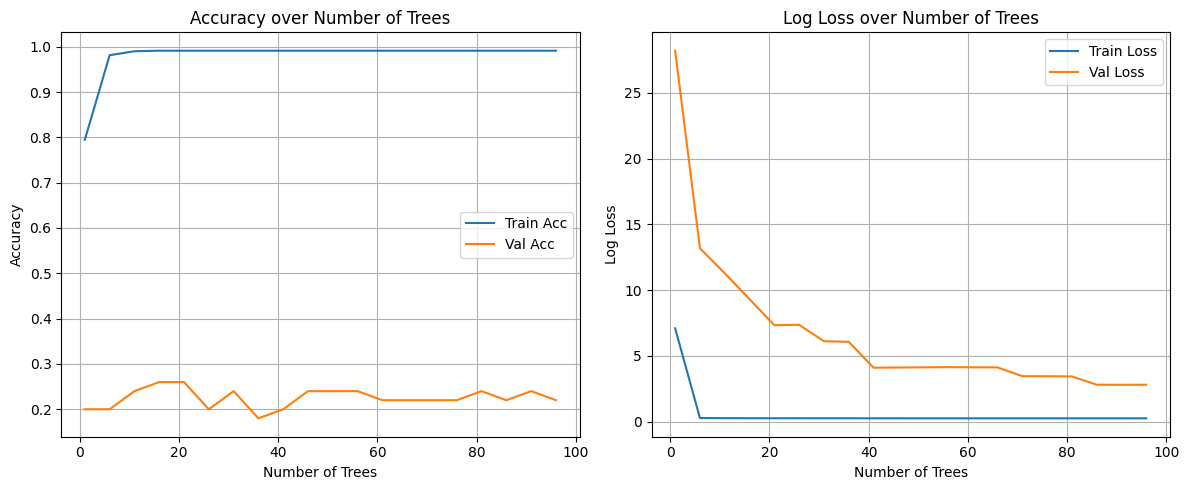

In [ ]:
n_estimators_max = 100  # Tổng số cây muốn train (tương đương epochs)
step_size = 5           # Cứ sau 5 cây thì đo loss/acc một lần (để chạy cho nhanh)

# Khởi tạo mô hình với warm_start=True
# warm_start=True giúp giữ lại kết quả cũ để train tiếp thêm cây mới (không train lại từ đầu)
rf_model = RandomForestClassifier(
    n_estimators=1,       # Bắt đầu với 1 cây
    max_depth=None,       
    n_jobs=-1, 
    random_state=42, 
    warm_start=True,      # QUAN TRỌNG: Cho phép train tiếp
    criterion='entropy'   # Dùng entropy để tính loss chính xác hơn
)

# Lists để lưu lịch sử
history = {
    'trees': [],
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': []
}

print(f" Bắt đầu huấn luyện Random Forest (Max Trees: {n_estimators_max})...")
print(f"{'Trees':<10} | {'Train Acc':<10} | {'Val Acc':<10} | {'Val Loss':<10}")
print("-" * 50)

# --- VÒNG LẶP TRAIN (Giả lập Epoch) ---
for i in range(1, n_estimators_max + 1, step_size):
    # Cập nhật số lượng cây
    rf_model.set_params(n_estimators=i)
    
    # Train (chỉ train thêm các cây mới)
    rf_model.fit(X_train, y_train)
    
    # --- TÍNH TOÁN METRICS ---
    # 1. Accuracy
    train_acc = rf_model.score(X_train, y_train)
    val_acc = rf_model.score(X_val, y_val)
    
    # 2. Log Loss (Cần xác suất dự đoán - predict_proba)
    # Loss càng thấp càng tốt
    y_pred_train_prob = rf_model.predict_proba(X_train)
    y_pred_val_prob = rf_model.predict_proba(X_val)
    
    train_loss = log_loss(y_train, y_pred_train_prob)
    val_loss = log_loss(y_val, y_pred_val_prob)
    
    # Lưu history
    history['trees'].append(i)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print(f"{i:<10} | {train_acc:.4f}     | {val_acc:.4f}     | {val_loss:.4f}")

print("-" * 50)

# --- ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST ---
test_acc = rf_model.score(X_test, y_test)
print(f" Final Test Accuracy: {test_acc:.4f}")

# Lưu mô hình
joblib.dump(rf_model, "gesture_rf_model.pkl")
print(" Đã lưu mô hình.")

# --- VẼ BIỂU ĐỒ (VISUALIZATION) ---
plt.figure(figsize=(12, 5))

# Biểu đồ Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['trees'], history['train_acc'], label='Train Acc')
plt.plot(history['trees'], history['val_acc'], label='Val Acc')
plt.title('Accuracy over Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(history['trees'], history['train_loss'], label='Train Loss')
plt.plot(history['trees'], history['val_loss'], label='Val Loss')
plt.title('Log Loss over Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# # --- BIỂU ĐỒ 1: MA TRẬN NHẦM LẪN (CONFUSION MATRIX) ---
# # Dùng để xem nhãn nào bị dự đoán sai nhiều nhất
# y_pred = rf_model.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# labels = list(class_map.keys())

# fig, ax = plt.subplots(figsize=(10, 8))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
# plt.title("Ma trận nhầm lẫn - Random Forest")
# plt.show()

# # --- BIỂU ĐỒ 2: TẦM QUAN TRỌNG ĐẶC TRƯNG (FEATURE IMPORTANCE) ---
# # Dùng để xem tọa độ nào có ảnh hưởng lớn nhất đến quyết định của mô hình
# importances = rf_model.feature_importances_
# # Lấy ra 20 đặc trưng (tọa độ/frame) quan trọng nhất trong tổng số 3780 đặc trưng
# indices = np.argsort(importances)[-20:] 

# plt.figure(figsize=(10, 6))
# plt.title("Top 20 tọa độ/frame quan trọng nhất")
# plt.barh(range(len(indices)), importances[indices], align='center')
# plt.yticks(range(len(indices)), indices)
# plt.xlabel("Độ quan trọng (Gini Importance)")
# plt.show()

In [ ]:
# LOAD MODEL
MODEL_PATH = "gesture_rf_model.pkl"
try:
    model = joblib.load(MODEL_PATH)
    print("Model loaded.")
except:
    print(" Model not found.")
    exit()

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# --- HÀM XỬ LÝ ---
def extract_and_normalize(frame_landmarks):
    coords = []
    for lm in frame_landmarks.landmark:
        coords.extend([lm.x, lm.y, lm.z])
    coords = np.array(coords)
    # Chuẩn hóa về cổ tay
    coords_reshaped = coords.reshape(-1, 3)
    coords_reshaped -= coords_reshaped[0] # Trừ đi điểm đầu tiên (cổ tay)
    return coords_reshaped.flatten()

def preprocess_input(frames_data, target_frames=30):
    vals = np.array(frames_data)
    if len(vals) == 0: return None
    # Sampling về 30 frames
    if len(vals) < target_frames:
        pad = np.zeros((target_frames - len(vals), vals.shape[1]))
        vals = np.vstack([vals, pad])
    elif len(vals) > target_frames:
        indices = np.linspace(0, len(vals)-1, target_frames).astype(int)
        vals = vals[indices]
    return vals.flatten().reshape(1, -1)

# --- CHẠY WEBCAM DEBUG ---
cap = cv2.VideoCapture(0)
frames_data = []
recording = False # Biến trạng thái: Đang quay hay không

print("\n HƯỚNG DẪN:")
print("1. Nhấn 'r' để BẮT ĐẦU hành động (Reset data cũ).")
print("2. Làm hành động trong 2-3 giây.")
print("3. Nhấn 'p' để DỰ ĐOÁN (Predict).")
print("4. Nhấn 'q' để Thoát.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    # THỬ ĐỔI DÒNG NÀY: Có lật hay không?
    frame = cv2.flip(frame, 1) 
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb)
    
    frame_vector = np.zeros(126)
    hand_status = "No Hand"
    
    if results.multi_hand_landmarks:
        for idx, hand_info in enumerate(results.multi_handedness):
            label = hand_info.classification[0].label # "Left" / "Right"
            hand_status = f"Hand: {label}" # Hiện lên màn hình để check
            
            landmarks = results.multi_hand_landmarks[idx]
            norm_coords = extract_and_normalize(landmarks)
            
            if label == "Left": frame_vector[0:63] = norm_coords
            else: frame_vector[63:126] = norm_coords
            
            # Vẽ
            mp.solutions.drawing_utils.draw_landmarks(frame, landmarks, mp_hands.HAND_CONNECTIONS)
            
        if recording:
            frames_data.append(frame_vector)

    # --- HIỂN THỊ GUI ---
    color = (0, 255, 0) if recording else (0, 0, 255)
    status_text = f"Recording: {len(frames_data)} frames" if recording else "Press 'r' to Start"
    
    cv2.putText(frame, status_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    cv2.putText(frame, hand_status, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    cv2.imshow("Debug Mode", frame)
    
    key = cv2.waitKey(1) & 0xFF
    
    # Bấm R để quay lại từ đầu
    if key == ord('r'):
        frames_data = []
        recording = True
        print(" Bắt đầu quay...")
        
    # Bấm P để dự đoán
    elif key == ord('p'):
        recording = False
        if len(frames_data) < 10:
            print(" Quá ít frame! Hãy quay dài hơn.")
        else:
            input_vec = preprocess_input(frames_data)
            pred = model.predict(input_vec)[0]
            prob = np.max(model.predict_proba(input_vec)[0]) * 100
            
            # In kết quả to đùng ra console
            print("\n" + "#"*30)
            print(f" DỰ ĐOÁN: Nhãn {int(pred)}")
            print(f" Tự tin: {prob:.2f}%")
            print("#"*30 + "\n")
            
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

✅ Model loaded.

🔴 HƯỚNG DẪN:
1. Nhấn 'r' để BẮT ĐẦU hành động (Reset data cũ).
2. Làm hành động trong 2-3 giây.
3. Nhấn 'p' để DỰ ĐOÁN (Predict).
4. Nhấn 'q' để Thoát.
▶️ Bắt đầu quay...

##############################
🎯 DỰ ĐOÁN: Nhãn 9
💪 Tự tin: 37.50%
##############################

▶️ Bắt đầu quay...

##############################
🎯 DỰ ĐOÁN: Nhãn 9
💪 Tự tin: 48.96%
##############################

